## TensorFlow - LSTM
In this notebook we will implement LSTM layer from scratch. Then we will use **LSTM** layer to do time series prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline

In [2]:
# Lets define these variables
# N = number of samples
# T = sequence length
# D = number of input features
# M = number of hidden units
# K = number of output units

np.random.seed(42)
N = 1
T = 1
D = 3
K = 2
X = np.random.randn(N, T, D)

In [5]:
# Make an LSTM
M = 5 # number of hidden units
i = Input(shape=(T, D))
x = LSTM(M)(i)
x = Dense(K)(x)

model = Model(i, x)

In [6]:
# Get the output 
Yhat = model.predict(X)
print(Yhat)

[[-0.09111997  0.06893993]]


In [7]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 180       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 12        
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Check the shapes of the layers
a, b, c = model.layers[1].get_weights()
print(a.shape, b.shape, c.shape)

(3, 20) (5, 20) (20,)


In [9]:
Wx, Wh, bh = model.layers[1].get_weights()
Wo, bo = model.layers[2].get_weights()

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#Initialize the hidden state
h_last = np.zeros(M)
c_last = np.zeros(M)
#First sample
x = X[0] 
Yhats = []

for t in range(T):
    f = sigmoid(x[t].dot(Wx[:,5:10]) + h_last.dot(Wh[:,5:10]) + bh[5:10]) 
    i = sigmoid(x[t].dot(Wx[:,0:5]) + h_last.dot(Wh[:,0:5]) + bh[0:5]) 
    o = sigmoid(x[t].dot(Wx[:,15:20]) + h_last.dot(Wh[:,15:20]) + bh[15:20]) 
    c = f * c_last + i * np.tanh(x[t].dot(Wx[:,10:15]) + h_last.dot(Wh[:,10:15]) + bh[10:15])
    h = o * np.tanh(c)
    y = h.dot(Wo) + bo 
    Yhats.append(y)
  
    h_last = h
    c_last = c

# print the final output
print(Yhats[-1])

[-0.09111999  0.06893994]


Our implementation of **LSTM** layer matches TensorFlow

In [11]:
#Lets make synthetic data
# make the original data
series = np.sin(np.linspace(0,10*np.pi,1000)**2)

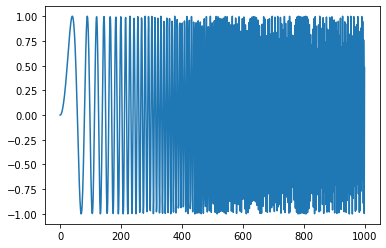

In [12]:
plt.plot(series)

In [13]:
### build the dataset
T = 200
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (800, 200) Y.shape (800,)


In [14]:
#LSTM Model
X = X.reshape(-1, T, 1) # make it N x T x D

i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:600], Y[:600],
  batch_size=32,
  epochs=200,
  validation_data=(X[600:], Y[600:]),
)

Epoch 1/200
19/19 [==============================] - 2s 83ms/step - loss: 0.2927 - val_loss: 0.6128
Epoch 2/200
19/19 [==============================] - 1s 49ms/step - loss: 0.4235 - val_loss: 0.5111
Epoch 3/200
19/19 [==============================] - 1s 47ms/step - loss: 0.1915 - val_loss: 0.7009
Epoch 4/200
19/19 [==============================] - 1s 46ms/step - loss: 0.1584 - val_loss: 0.5763
Epoch 5/200
19/19 [==============================] - 1s 44ms/step - loss: 0.1154 - val_loss: 0.5353
Epoch 6/200
19/19 [==============================] - 1s 48ms/step - loss: 0.0829 - val_loss: 0.4892
Epoch 7/200
19/19 [==============================] - 1s 49ms/step - loss: 0.0594 - val_loss: 0.5496
Epoch 8/200
19/19 [==============================] - 1s 49ms/step - loss: 0.0549 - val_loss: 0.4499
Epoch 9/200
19/19 [==============================] - 1s 52ms/step - loss: 0.0576 - val_loss: 0.4790
Epoch 10/200
19/19 [==============================] - 1s 49ms/step - loss: 0.0548 - val_loss: 0.5735

19/19 [==============================] - 1s 54ms/step - loss: 0.0849 - val_loss: 0.5438
Epoch 83/200
19/19 [==============================] - 1s 68ms/step - loss: 0.0730 - val_loss: 0.4514
Epoch 84/200
19/19 [==============================] - 1s 57ms/step - loss: 0.0683 - val_loss: 0.5124
Epoch 85/200
19/19 [==============================] - 1s 63ms/step - loss: 0.0660 - val_loss: 0.4430
Epoch 86/200
19/19 [==============================] - 1s 63ms/step - loss: 0.0598 - val_loss: 0.4871
Epoch 87/200
19/19 [==============================] - 1s 62ms/step - loss: 0.0586 - val_loss: 0.4506
Epoch 88/200
19/19 [==============================] - 1s 56ms/step - loss: 0.0540 - val_loss: 0.4677
Epoch 89/200
19/19 [==============================] - 1s 57ms/step - loss: 0.0526 - val_loss: 0.4106
Epoch 90/200
19/19 [==============================] - 1s 56ms/step - loss: 0.0540 - val_loss: 0.4342
Epoch 91/200
19/19 [==============================] - 1s 54ms/step - loss: 0.0501 - val_loss: 0.3809
Epo

19/19 [==============================] - 1s 60ms/step - loss: 0.0063 - val_loss: 0.1947
Epoch 163/200
19/19 [==============================] - 1s 61ms/step - loss: 0.0059 - val_loss: 0.1888
Epoch 164/200
19/19 [==============================] - 1s 58ms/step - loss: 0.0060 - val_loss: 0.2015
Epoch 165/200
19/19 [==============================] - 1s 59ms/step - loss: 0.0058 - val_loss: 0.1956
Epoch 166/200
19/19 [==============================] - 1s 68ms/step - loss: 0.0047 - val_loss: 0.1879
Epoch 167/200
19/19 [==============================] - 1s 54ms/step - loss: 0.0049 - val_loss: 0.1903
Epoch 168/200
19/19 [==============================] - 1s 51ms/step - loss: 0.0050 - val_loss: 0.2098
Epoch 169/200
19/19 [==============================] - 1s 49ms/step - loss: 0.0063 - val_loss: 0.1945
Epoch 170/200
19/19 [==============================] - 1s 49ms/step - loss: 0.0048 - val_loss: 0.1873
Epoch 171/200
19/19 [==============================] - 1s 59ms/step - loss: 0.0051 - val_loss: 0

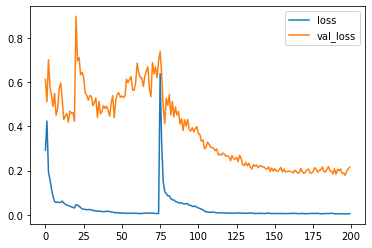

In [15]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

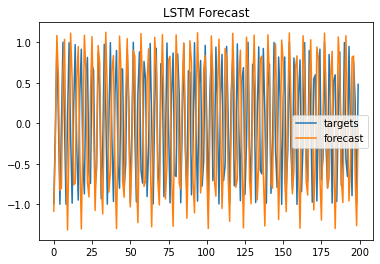

In [16]:
# Multi-step forecast
forecast = []
input = X[600]
while len(forecast) < len(Y[600:800]):
  # Reshape the input to N x T x D
  f = model.predict(input.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input = np.roll(input, -1)
  input[-1] = f

plt.plot(Y[600:800], label='targets')
plt.plot(forecast, label='forecast')
plt.title("LSTM Forecast")
plt.legend()
plt.show()

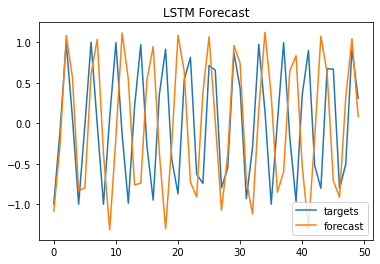

In [17]:
plt.plot(Y[600:650], label='targets')
plt.plot(forecast[:50], label='forecast')
plt.title("LSTM Forecast")
plt.legend()
plt.show()

We can see from the above plots that LSTM did get some prediction correct